In this notebook, we explore the application of Graph Neural Networks (GNNs) to analyze and classify data from the Cora dataset. The Cora dataset is a standard citation network dataset widely used for benchmarking node classification algorithms.


**Library and Environment Setup**

Import necessary libraries including PyTorch, PyTorch Geometric, and others.
Set up the computing environment to use GPU if available.
Data Loading and Visualization:

**Load the Cora dataset using PyTorch Geometric**

Visualize the basic structure and properties of the dataset, including node features and class distribution.
Perform PCA to visualize the node features in a 2D space, ignoring the graph structure.

**Multilayer Perceptron (MLP) Implementation**

Prepare the data for training an MLP by converting it into tensors.
Split the data into training, validation, and test sets.
Define and train an MLP model, evaluate its performance using accuracy and other metrics.

**Graph Neural Network (GNN) Implementation**

Define a GNN model using the PyTorch Geometric library, which leverages the graph structure for node classification.
Prepare the dataset with masks to specify training, validation, and test nodes.

**Evaluation and Comparison**

Compare the performance of the MLP and GNN models.
Use evaluation metrics such as accuracy, classification report, and confusion matrix to assess the models.

In [1]:
# Import and install necessary libraries
!pip install torchsummary
!pip install imblearn
!pip install torch-geometric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00


In this section, we will import the Cora dataset using the PyTorch Geometric library. The Cora dataset is a standard citation network dataset commonly used for benchmarking graph neural networks. It consists of scientific publications (nodes) classified into one of seven classes. Each publication cites or is cited by other publications (edges). Each node is characterized by a feature vector whose elements are 0/1 indicating the absence/presence of the corresponding word from a dictionary.

We will load the dataset and visualize some basic properties, such as the number of nodes, edges, and the distribution of classes. This will help us understand the structure and characteristics of the data before we proceed with building our graph neural network.

Dataset: Cora
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of node features: 1433
Number of classes: 7

First 10 node features:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

First 10 labels:
tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])


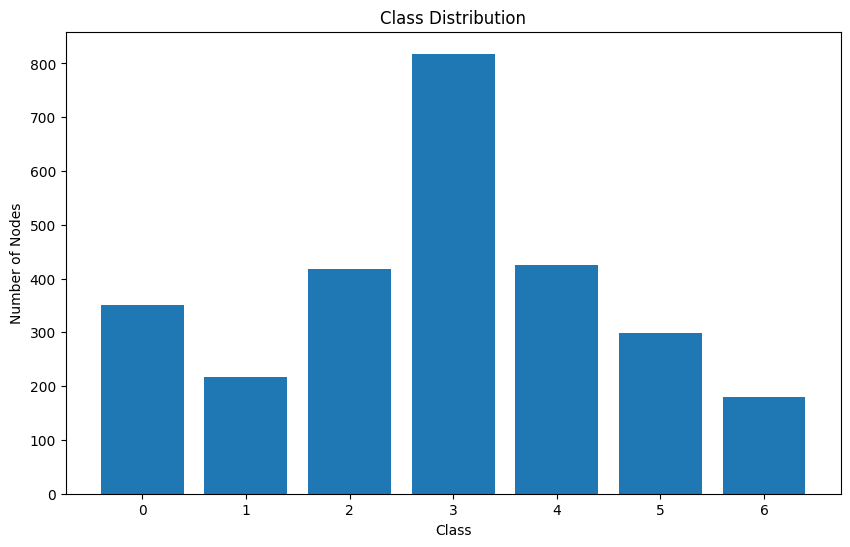

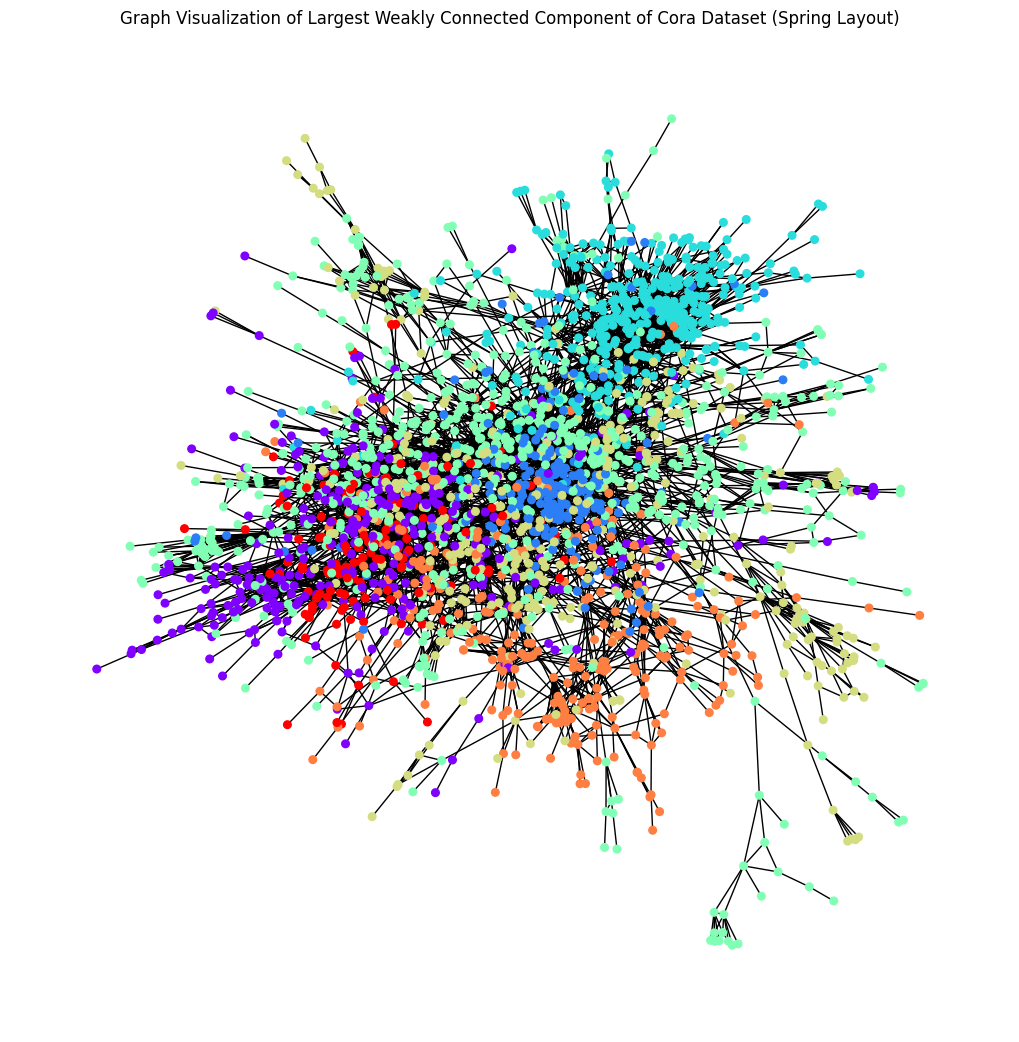

In [5]:
# Importing the necessary packages for data handling and visualization
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Display basic information about the dataset
print(f'Dataset: {dataset.name}')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

# Visualize the first 10 node features and the first 10 labels
print('\nFirst 10 node features:')
print(data.x[:10])
print('\nFirst 10 labels:')
print(data.y[:10])

# Visualize the class distribution
plt.figure(figsize=(10, 6))
plt.hist(data.y.numpy(), bins=range(dataset.num_classes+1), align='left', rwidth=0.8)
plt.xticks(range(dataset.num_classes))
plt.xlabel('Class')
plt.ylabel('Number of Nodes')
plt.title('Class Distribution')
plt.show()


# Convert the data to a NetworkX graph for visualization (keeping it directed)
G = to_networkx(data, to_undirected=True)

# Extract the largest weakly connected component
largest_wcc = max(nx.connected_components(G), key=len)
G_lwcc = G.subgraph(largest_wcc).copy()

# Apply the spring layout algorithm
pos = nx.spring_layout(G_lwcc)

# Plot the largest weakly connected component with spring layout
plt.figure(figsize=(10, 10))
nx.draw(G_lwcc, pos, node_size=30, node_color=[data.y[i] for i in G_lwcc.nodes()], cmap=plt.cm.rainbow, with_labels=False, arrows=True)
plt.title('Graph Visualization of Largest Weakly Connected Component of Cora Dataset (Spring Layout)')
plt.show()

In this section, we will use Principal Component Analysis (PCA) to visualize the node features of the Cora dataset in a two-dimensional plane. By plotting the nodes in the plane defined by the first two principal components, we can observe patterns and relationships in the data, ignoring the graph structure. This can provide insights into the distribution and separability of the classes based solely on their feature vectors.

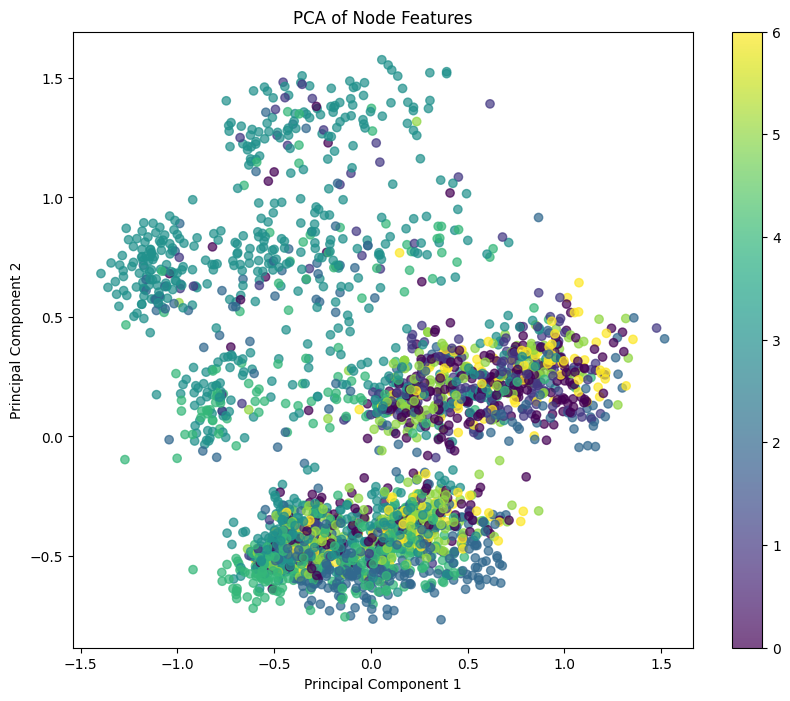

In [6]:
# Importing necessary packages for PCA and visualization
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA on the node features
pca = PCA(n_components=2)
node_features_2d = pca.fit_transform(data.x.numpy())

# Plot the 2D PCA result with nodes colored by their class labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(node_features_2d[:, 0], node_features_2d[:, 1], c=data.y.numpy(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(dataset.num_classes))
plt.title('PCA of Node Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In this section, we will preprocess the data to be used with a Multilayer Perceptron (MLP) model, ignoring the graph structure. We will split the data into training and validation sets to monitor the model's performance and implement early stopping during training. This helps prevent overfitting by stopping the training process when the validation performance stops improving.

We will use the node features as input features for the MLP and the class labels as targets for a multiclass classification task.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Extract node features and labels
X = data.x.numpy()
y = data.y.numpy()

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split data into training, validation, and test sets (30% train, 10% val, 60% test)
train_size = int(0.3 * len(X_tensor))
val_size = int(0.1 * len(X_tensor))
test_size = len(X_tensor) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    TensorDataset(X_tensor, y_tensor),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

Here we define a Multilayer Perceptron (MLP) model using PyTorch. Nothing new.

In [8]:
# Define the MLP model for multiclass classification
class MLP_Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, output_dim),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = X_tensor.shape[1]
output_dim = dataset.num_classes
model = MLP_Classifier(input_dim, output_dim).to(device)

# Summary of the model structure
from torchsummary import summary
summary(model, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          45,888
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
              ReLU-5                   [-1, 16]               0
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 7]             119
        LogSoftmax-8                    [-1, 7]               0
Total params: 46,535
Trainable params: 46,535
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.18
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


Early stopping and training function.

In [9]:
#EARLY STOPPING

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

# Function for training the model
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('mlp_checkpoint.pt'))
    return train_losses, val_losses

Here we train the MLP and we plot the loss functions over the training epochs.

Epoch: 1, Training Loss: 1.9488, Validation Loss: 1.9483
Validation loss decreased (33.121614 --> 33.121614).  Saving model ...
Epoch: 2, Training Loss: 1.9439, Validation Loss: 1.9430
Validation loss decreased (33.121614 --> 33.031692).  Saving model ...
Epoch: 3, Training Loss: 1.9361, Validation Loss: 1.9369
Validation loss decreased (33.031692 --> 32.927020).  Saving model ...
Epoch: 4, Training Loss: 1.9321, Validation Loss: 1.9303
Validation loss decreased (32.927020 --> 32.815495).  Saving model ...
Epoch: 5, Training Loss: 1.9256, Validation Loss: 1.9230
Validation loss decreased (32.815495 --> 32.691711).  Saving model ...
Epoch: 6, Training Loss: 1.9203, Validation Loss: 1.9155
Validation loss decreased (32.691711 --> 32.564218).  Saving model ...
Epoch: 7, Training Loss: 1.9130, Validation Loss: 1.9075
Validation loss decreased (32.564218 --> 32.428224).  Saving model ...
Epoch: 8, Training Loss: 1.9029, Validation Loss: 1.8983
Validation loss decreased (32.428224 --> 32.271

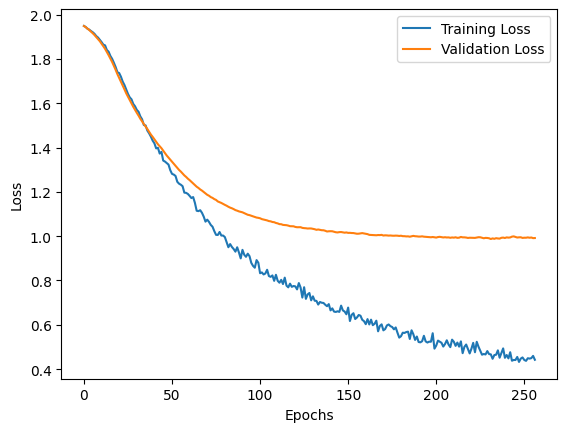

In [10]:
# Create DataLoaders for the datasets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Initialize early stopping
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='mlp_checkpoint.pt')

# Train the model and plot losses
epochs = 500
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In this section, we will evaluate the performance of our trained Multilayer Perceptron (MLP) model on the validation set. We will use several metrics, including accuracy, classification report (precision, recall, F1-score), and confusion matrix to provide a comprehensive overview of the model's performance.

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

# Function to evaluate the model on the validation set
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # If the model returns a tuple, select only the logits
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            y_preds.extend(predicted.view(-1).cpu().numpy())  # Store predictions
            y_true.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_preds))

    return accuracy

# Evaluate CNN model
print("\n---------------CNN MODEL---------------\n")
cnn_accuracy = evaluate_model(val_loader, model)


---------------CNN MODEL---------------

Accuracy: 0.7
Classification Report:
               precision    recall  f1-score   support

           0     0.6154    0.5714    0.5926        28
           1     0.7647    0.4815    0.5909        27
           2     0.8571    0.7826    0.8182        46
           3     0.7670    0.8316    0.7980        95
           4     0.5556    0.7353    0.6329        34
           5     0.5000    0.5769    0.5357        26
           6     0.7143    0.3571    0.4762        14

    accuracy                         0.7000       270
   macro avg     0.6820    0.6195    0.6349       270
weighted avg     0.7113    0.7000    0.6967       270

Confusion Matrix:
 [[16  0  1  4  2  5  0]
 [ 2 13  1  5  4  1  1]
 [ 1  1 36  6  1  1  0]
 [ 3  2  1 79  9  1  0]
 [ 0  1  0  4 25  4  0]
 [ 1  0  2  3  4 15  1]
 [ 3  0  1  2  0  3  5]]


Now that we have evaluated the performance of a Multilayer Perceptron (MLP) on our dataset, we will move to the core of this notebook: implementing and training a Graph Neural Network (GNN). Unlike the MLP, which ignores the graph structure, the GNN leverages the connections between nodes to improve classification performance.

Graph Neural Networks are designed to operate directly on the graph structure. They use message passing to aggregate information from a node's neighbors, allowing the model to learn from both the features and the structure of the graph.

In this section, we will define a simple GNN model using the PyTorch Geometric library, which provides convenient utilities for working with graph data. Our model will consist of two graph convolutional layers followed by a classification layer.

In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the Graph Neural Network (GNN) model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Set the dimensions for input, hidden, and output layers
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = dataset.num_classes

# Instantiate the GNN model and move it to the device (GPU or CPU)
gnn_model = GNN(input_dim, hidden_dim, output_dim).to(device)

# Print the model architecture
print(gnn_model)

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In this section, we prepare the dataset with masks for training, validation, and test sets. Masking is a crucial technique for graph data in PyTorch Geometric, as it allows us to specify which nodes should be used for training, validation, and testing.

Masks are used to partition the nodes of a graph into different subsets for training, validation, and testing. This ensures that we evaluate the model's performance on data that it has not seen during training, providing a more accurate measure of its generalization capability.

In [14]:
# Define the custom collate function for DataLoader (We need this since we only have 1 graph so there is no batch.)
def collate_fn(batch):
    return batch[0]

# Preparing the dataset with masks for training, validation, and test
# Creating masks for training, validation, and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[:train_size] = True
val_mask[train_size:train_size + val_size] = True
test_mask[train_size + val_size:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Create DataLoader for the GNN model using the custom collate function
train_loader = DataLoader([data], batch_size=1, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader([data], batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader([data], batch_size=1, shuffle=False, collate_fn=collate_fn)

Next, we will train our Graph Neural Network (GNN) using the same dataset and training procedure as the MLP. We will leverage the same training function and early stopping mechanism to ensure consistency and facilitate comparison between the two models.

The GNN will be trained on the node features and the graph structure, aiming to improve the classification performance by utilizing the connectivity information in the data.



Epoch: 1, Training Loss: 1.9395, Validation Loss: 1.9318
Validation loss decreased (1.931790 --> 1.931790).  Saving model ...
Epoch: 2, Training Loss: 1.9317, Validation Loss: 1.9211
Validation loss decreased (1.931790 --> 1.921102).  Saving model ...
Epoch: 3, Training Loss: 1.9194, Validation Loss: 1.9106
Validation loss decreased (1.921102 --> 1.910615).  Saving model ...
Epoch: 4, Training Loss: 1.9074, Validation Loss: 1.8999
Validation loss decreased (1.910615 --> 1.899926).  Saving model ...
Epoch: 5, Training Loss: 1.8974, Validation Loss: 1.8891
Validation loss decreased (1.899926 --> 1.889089).  Saving model ...
Epoch: 6, Training Loss: 1.8846, Validation Loss: 1.8781
Validation loss decreased (1.889089 --> 1.878057).  Saving model ...
Epoch: 7, Training Loss: 1.8727, Validation Loss: 1.8667
Validation loss decreased (1.878057 --> 1.866715).  Saving model ...
Epoch: 8, Training Loss: 1.8616, Validation Loss: 1.8551
Validation loss decreased (1.866715 --> 1.855079).  Saving mo

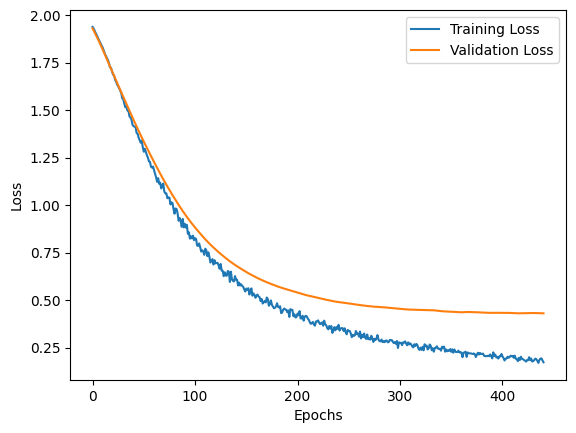

In [15]:
# Define the training function for the GNN (reusing the previous function)
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output[data.val_mask], data.y[data.val_mask])
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('gnn_checkpoint.pt'))
    return train_losses, val_losses

# Define the optimizer and loss function
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

# Initialize early stopping
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='gnn_checkpoint.pt')

# Train the GNN model
epochs = 500
train_losses, val_losses = train_model(epochs, gnn_model, optimizer, criterion, train_loader, val_loader, early_stopper)

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Finally we can evaluate our GNN. We have to modify our evaluation function to work with the masks, but the concept is always the same.

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

# Function to evaluate the model on the validation or test set
def evaluate_model(data_loader, model, mask_type='val'):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Determine the appropriate mask
    if mask_type == 'val':
        mask_attr = 'val_mask'
    elif mask_type == 'test':
        mask_attr = 'test_mask'
    else:
        raise ValueError("mask_type must be 'val' or 'test'")

    # Collect all labels and model outputs
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data)
            mask = getattr(data, mask_attr)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # If the model returns a tuple, select only the logits
            _, predicted = torch.max(outputs[mask], 1)  # Get the index of the max log-probability for the mask
            y_preds.extend(predicted.cpu().numpy())  # Store predictions
            y_true.extend(data.y[mask].cpu().numpy())  # Store true labels

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_preds))

    return accuracy

# Evaluate GNN model on validation set
print("\n---------------GNN MODEL (Validation)---------------\n")
gnn_val_accuracy = evaluate_model(val_loader, gnn_model, mask_type='val')

# Evaluate GNN model on test set
print("\n---------------GNN MODEL (Test)---------------\n")
gnn_test_accuracy = evaluate_model(test_loader, gnn_model, mask_type='test')


---------------GNN MODEL (Validation)---------------

Accuracy: 0.8740740740740741
Classification Report:
               precision    recall  f1-score   support

           0     0.7895    0.8824    0.8333        34
           1     0.6667    0.8000    0.7273        15
           2     0.9184    0.9574    0.9375        47
           3     0.9091    0.9091    0.9091        88
           4     1.0000    0.8837    0.9383        43
           5     0.7917    0.7037    0.7451        27
           6     0.8000    0.7500    0.7742        16

    accuracy                         0.8741       270
   macro avg     0.8393    0.8409    0.8378       270
weighted avg     0.8784    0.8741    0.8746       270

Confusion Matrix:
 [[30  1  1  2  0  0  0]
 [ 0 12  1  2  0  0  0]
 [ 0  1 45  0  0  1  0]
 [ 3  3  1 80  0  1  0]
 [ 0  1  0  3 38  1  0]
 [ 3  0  1  1  0 19  3]
 [ 2  0  0  0  0  2 12]]

---------------GNN MODEL (Test)---------------

Accuracy: 0.8622386223862238
Classification Report:
      